## Uber prices with Ridge Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = [7, 5]
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('train.csv')
data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,product_id,name,price,distance,surge_multiplier,latitude,longitude,temperature,apparentTemperature,short_summary,long_summary,precipIntensity,precipProbability,humidity,windSpeed,windGust,windGustTime,visibility,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,icon,dewPoint,pressure,windBearing,cloudCover,uvIndex,visibility.1,ozone,sunriseTime,sunsetTime,moonPhase,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,885116c8-8e5c-4d4e-af4d-1fd53c6b2464,1.543564e+09,7,30,11,2018-11-30 07:47:56,America/New_York,North Station,South Station,Lyft,lyft,Lyft,9.0,2.07,1.0,42.3559,-71.0550,30.42,30.42,Clear,Mostly cloudy throughout the day.,0.0000,0.0,0.85,2.19,2.88,1543554000,9.944,42.64,1543600800,31.57,1543658400,40.61,1543611600,27.88,1543658400,clear-night,26.43,1014.74,319,0.00,0,9.944,286.9,1543578866,1543612472,0.79,0.0003,1543593600,28.78,1543579200,42.64,1543600800,26.35,1543575600,40.61,1543611600
1,93fb610d-bb94-45bc-98b8-0a4a2e349ab2,1.544822e+09,21,14,12,2018-12-14 21:20:11,America/New_York,West End,South Station,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,27.0,2.14,1.0,42.3398,-71.0892,42.91,41.40,Mostly Cloudy,Partly cloudy throughout the day.,0.0000,0.0,0.66,3.25,4.37,1544846400,9.570,46.90,1544814000,40.75,1544835600,44.15,1544817600,38.71,1544835600,partly-cloudy-night,32.34,1029.10,186,0.73,0,9.570,290.2,1544789239,1544822023,0.24,0.0000,1544806800,26.76,1544788800,46.90,1544814000,27.41,1544788800,44.15,1544817600
2,69244a0f-6ec6-4265-b73e-3dcb069d671e,1.543834e+09,10,3,12,2018-12-03 10:52:59,America/New_York,Theatre District,Boston University,Lyft,lyft_line,Shared,10.5,4.80,1.0,42.2148,-71.0330,48.43,48.43,Overcast,Foggy in the morning.,0.0000,0.0,0.94,2.74,2.74,1543860000,3.729,57.87,1543852800,32.80,1543921200,57.20,1543852800,27.22,1543914000,cloudy,46.70,999.67,213,1.00,0,3.729,296.7,1543838223,1543871641,0.89,0.0007,1543852800,42.96,1543896000,57.87,1543852800,39.41,1543896000,57.20,1543852800
3,230cbecb-368e-4b8d-b9f1-67a40f68991f,1.543759e+09,14,2,12,2018-12-02 14:03:04,America/New_York,Boston University,Back Bay,Uber,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,7.0,0.03,1.0,42.3588,-71.0707,43.51,39.58,Light Rain,Light rain until evening.,0.0832,1.0,0.96,6.60,8.47,1543755600,2.644,50.73,1543788000,44.99,1543816800,50.06,1543788000,45.64,1543816800,rain,42.47,1015.25,117,1.00,1,2.644,276.0,1543751797,1543785238,0.86,0.0904,1543770000,36.45,1543726800,50.73,1543788000,35.85,1543748400,50.06,1543788000
4,6c873c64-967e-47f2-bd89-5ec6fd330aa3,1.544973e+09,15,16,12,2018-12-16 15:05:17,America/New_York,Financial District,North End,Lyft,lyft,Lyft,7.0,1.02,1.0,42.3647,-71.0542,42.25,37.39,Overcast,Rain throughout the day.,0.0000,0.0,0.74,7.86,8.19,1545015600,9.169,43.83,1544990400,34.25,1545044400,38.38,1544986800,28.30,1545044400,cloudy,34.39,1020.18,77,1.00,1,9.169,324.2,1544962119,1544994839,0.30,0.1252,1544979600,39.22,1544954400,43.83,1544990400,33.98,1545019200,38.38,1544986800


In [3]:
data.cab_type.unique()

array(['Lyft', 'Uber'], dtype=object)

In [4]:
# as Uber is the target company, the Lyft company is excluded
df = data.copy()
df.drop(df[(df['cab_type'] == 'Lyft')].index, inplace=True)

In [5]:
df.nunique()

id                             289273
timestamp                       31539
hour                               24
day                                17
month                               2
datetime                        29805
timezone                            1
source                             12
destination                        12
cab_type                            1
product_id                          7
name                                7
price                             120
distance                          422
surge_multiplier                    1
latitude                           11
longitude                          12
temperature                       308
apparentTemperature               319
short_summary                       9
long_summary                       11
precipIntensity                    63
precipProbability                  29
humidity                           51
windSpeed                         291
windGust                          286
windGustTime

Columns to drop:
- id;
- timestamp;
- datetime (duplicates the columns: hour, day, month; and the year 2018 is unique for all observations)
- product_id;
- cab_type, timezone, surge_multiplier (since they have only 1 unique value);
- short_summary, long_summary (the weather descr is kept in the 'icon' column).

In [6]:
df = df.drop(['id', 'timestamp', 'datetime', 'cab_type', 'product_id', 'timezone',
                'surge_multiplier', 'short_summary', 'long_summary'], axis=1)

In [7]:
df.isna().sum().sort_values(ascending=False)

price                          41280
hour                               0
sunsetTime                         0
icon                               0
dewPoint                           0
pressure                           0
windBearing                        0
cloudCover                         0
uvIndex                            0
visibility.1                       0
ozone                              0
sunriseTime                        0
moonPhase                          0
apparentTemperatureLow             0
precipIntensityMax                 0
uvIndexTime                        0
temperatureMin                     0
temperatureMinTime                 0
temperatureMax                     0
temperatureMaxTime                 0
apparentTemperatureMin             0
apparentTemperatureMinTime         0
apparentTemperatureMax             0
apparentTemperatureLowTime         0
apparentTemperatureHighTime        0
day                                0
precipIntensity                    0
m

In [8]:
df.dropna(axis=0, inplace=True)
df.rename(columns={'name': 'car_type', 'icon': 'weather_descr'}, inplace=True)
df.car_type.unique()

array(['Black SUV', 'UberX', 'WAV', 'UberXL', 'UberPool', 'Black'],
      dtype=object)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247993 entries, 1 to 519801
Data columns (total 48 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   hour                         247993 non-null  int64  
 1   day                          247993 non-null  int64  
 2   month                        247993 non-null  int64  
 3   source                       247993 non-null  object 
 4   destination                  247993 non-null  object 
 5   car_type                     247993 non-null  object 
 6   price                        247993 non-null  float64
 7   distance                     247993 non-null  float64
 8   latitude                     247993 non-null  float64
 9   longitude                    247993 non-null  float64
 10  temperature                  247993 non-null  float64
 11  apparentTemperature          247993 non-null  float64
 12  precipIntensity              247993 non-null  float64
 13 

Target Variable and Features

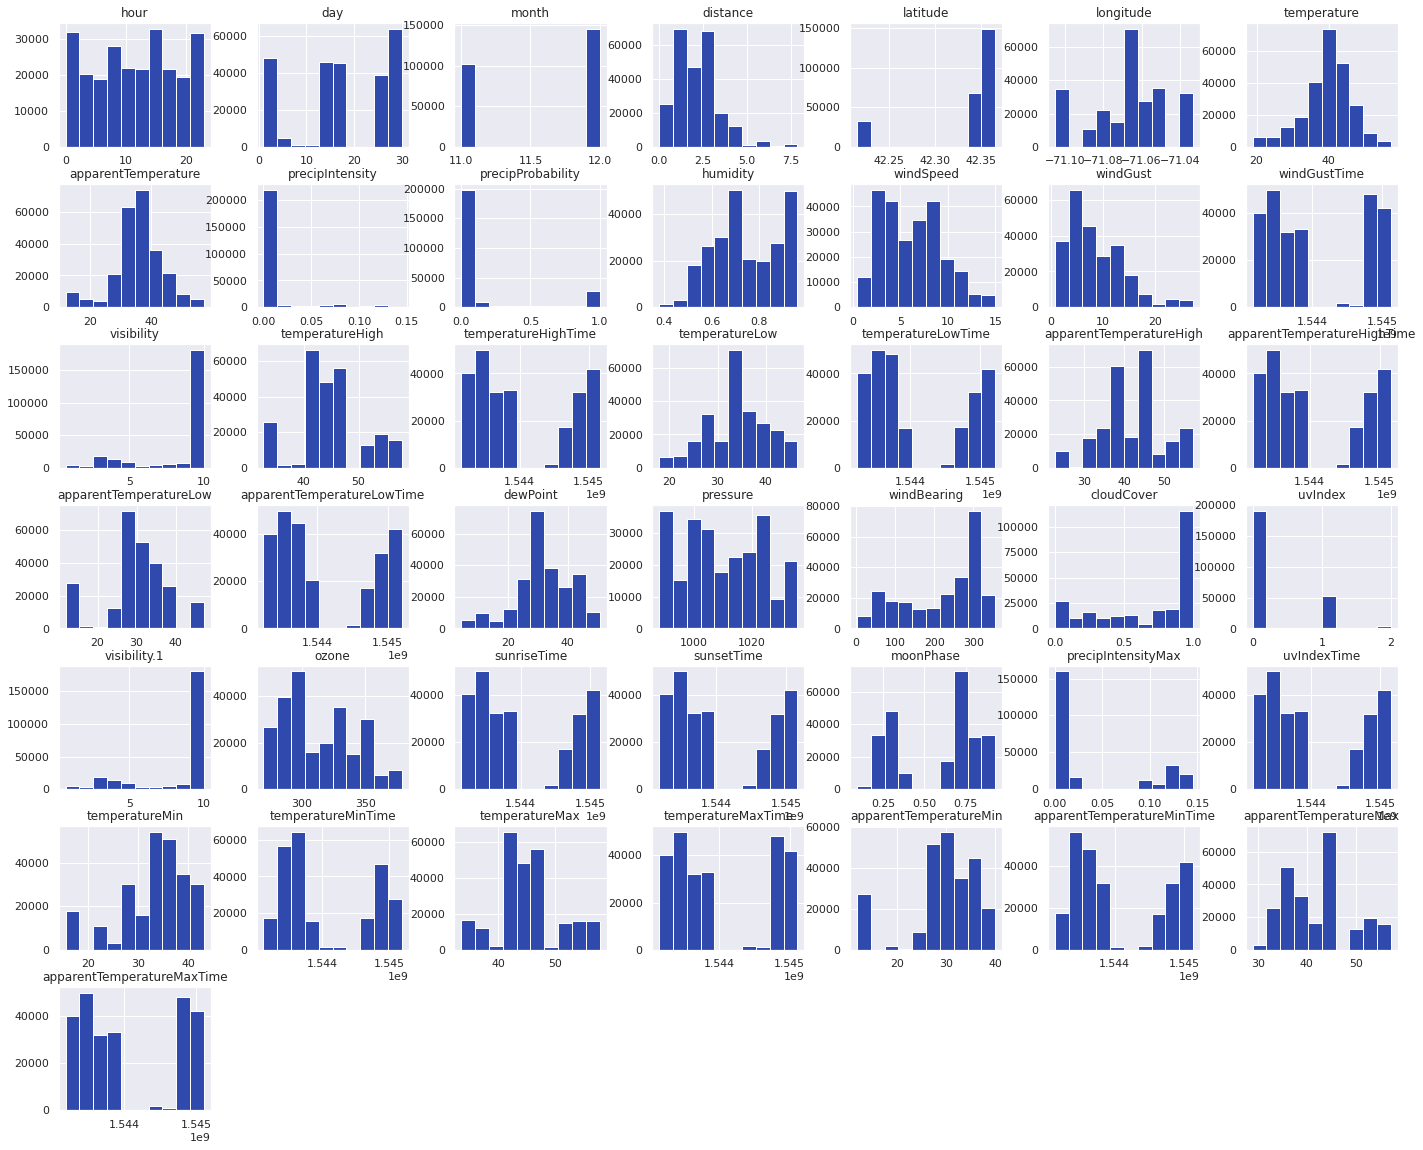

In [10]:
# Features distribution
df.drop('price', axis=1).hist(figsize=(24, 20), color='#3049AD');

In [11]:
corr_m = df.corr()
corr_m['price'].sort_values(ascending=False)

price                          1.000000
distance                       0.335205
windGust                       0.003216
precipIntensityMax             0.002926
windSpeed                      0.002197
latitude                       0.001920
day                            0.001563
visibility                     0.001465
visibility.1                   0.001465
temperature                    0.001458
ozone                          0.001209
apparentTemperature            0.001115
cloudCover                     0.001044
hour                           0.001037
precipIntensity                0.000929
temperatureMin                 0.000816
dewPoint                       0.000620
apparentTemperatureLow         0.000515
precipProbability              0.000457
apparentTemperatureMin         0.000013
moonPhase                     -0.000048
apparentTemperatureMax        -0.000057
temperatureMax                -0.000074
temperatureHigh               -0.000239
apparentTemperatureHigh       -0.000275


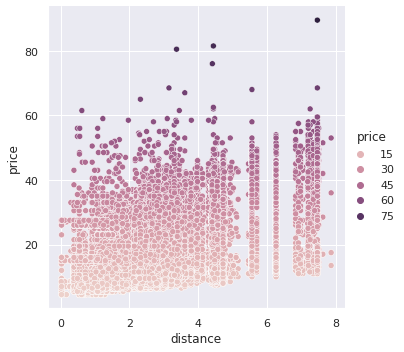

In [12]:
# Distance-price relation
sns.relplot(x='distance', y='price', hue='price', data=df)
plt.show('svg')

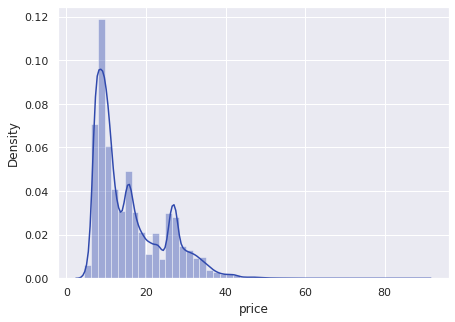

In [13]:
sns.distplot(df['price'], color="#3049AD")
plt.xticks(np.arange(0, 90, step=20))
plt.show('svg')

The distribution of the target variable is skewed to the right.<br>
The outliers will be imputed with the mean.

In [14]:
def outlier_detect_IQR(data, col, threshold=3):
    '''Define number and fraction of outliers.'''
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    para = (upper_fence, lower_fence)
    tmp = pd.concat([data[col] > upper_fence,
                    data[col] < lower_fence], axis=1)
    outlier_index = tmp.any(axis=1)
    print('Number of outliers:', outlier_index.value_counts()[1])
    print('Fraction of outliers:', outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index, para

In [15]:
index, para = outlier_detect_IQR(data=df, col='price')
print('Upper bound:', para[0], '\nLower bound:', para[1])

Number of outliers: 16
Fraction of outliers: 6.451795010343034e-05
Upper bound: 59.0 
Lower bound: -28.5


In [16]:
def impute_outlier_with_avg(data, col, outlier_index):
    '''Impute outliers with the mean.'''
    data_copy = data.copy(deep=True)
    data_copy.loc[outlier_index,col] = data_copy[col].mean()
    return data_copy

In [17]:
df = impute_outlier_with_avg(data=df, col='price', outlier_index=index)

One-Hot Encoding. There are 4 categorical features to convert into numeric values:
- source
- destination
- car_type
- weather_descr

In [18]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,hour,day,month,price,distance,latitude,longitude,temperature,apparentTemperature,precipIntensity,precipProbability,humidity,windSpeed,windGust,windGustTime,visibility,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,dewPoint,pressure,windBearing,cloudCover,uvIndex,visibility.1,ozone,sunriseTime,sunsetTime,moonPhase,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,car_type_Black SUV,car_type_UberPool,car_type_UberX,car_type_UberXL,car_type_WAV,weather_descr_ clear-night,weather_descr_ cloudy,weather_descr_ fog,weather_descr_ partly-cloudy-day,weather_descr_ partly-cloudy-night,weather_descr_ rain
1,21,14,12,27.0,2.14,42.3398,-71.0892,42.91,41.40,0.0000,0.00,0.66,3.25,4.37,1544846400,9.570,46.90,1544814000,40.75,1544835600,44.15,1544817600,38.71,1544835600,32.34,1029.10,186,0.73,0,9.570,290.2,1544789239,1544822023,0.24,0.0000,1544806800,26.76,1544788800,46.90,1544814000,27.41,1544788800,44.15,1544817600,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
3,14,2,12,7.0,0.03,42.3588,-71.0707,43.51,39.58,0.0832,1.00,0.96,6.60,8.47,1543755600,2.644,50.73,1543788000,44.99,1543816800,50.06,1543788000,45.64,1543816800,42.47,1015.25,117,1.00,1,2.644,276.0,1543751797,1543785238,0.86,0.0904,1543770000,36.45,1543726800,50.73,1543788000,35.85,1543748400,50.06,1543788000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
7,16,28,11,7.5,1.25,42.3661,-71.0631,41.16,35.84,0.0000,0.00,0.61,8.33,12.76,1543431600,10.000,42.60,1543438800,37.44,1543489200,36.58,1543438800,31.97,1543478400,28.91,991.41,297,0.81,1,10.000,352.0,1543405938,1543439718,0.72,0.0000,1543420800,33.75,1543399200,42.60,1543438800,29.97,1543399200,36.58,1543438800,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
8,5,15,12,18.5,2.20,42.3661,-71.0631,45.18,42.30,0.0000,0.00,0.93,5.38,8.31,1544918400,8.432,54.47,1544896800,38.94,1544954400,53.80,1544896800,35.08,1544950800,43.18,1022.76,219,1.00,0,8.432,298.0,1544875681,1544908425,0.27,0.0074,1544893200,39.54,1544929200,54.47,1544896800,36.46,1544929200,53.80,1544896800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
9,11,15,12,26.0,0.72,42.3647,-71.0542,47.34,46.24,0.0024,0.12,0.88,3.47,6.73,1544918400,8.099,54.40,1544896800,39.22,1544954400,53.73,1544896800,35.32,1544954400,43.91,1021.98,222,0.99,0,8.099,296.6,1544875679,1544908424,0.27,0.0075,1544893200,39.78,1544929200,54.40,1544896800,36.64,1544929200,53.73,1544896800,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [19]:
df.shape

(247993, 77)

In [20]:
X = df.drop(['price'], axis=1)
y = df['price']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=42)

In [22]:
# scaling, feature selection and regressor
steps = [('scaler', StandardScaler()),
        ('selectkbest', SelectKBest(f_regression)),
        ('ridge', Ridge())]

pipe = Pipeline(steps)

params = {'selectkbest__k': range(1, 11),
        'ridge__alpha': [0.001, 0.01, 0.1, 0.5, 1, 5, 10]}

In [23]:
grid_s = GridSearchCV(pipe, params, n_jobs=-1, cv=5)
grid_s.fit(X_train, y_train)
y_pred = grid_s.predict(X_test)

print('Best parameters: {}'.format(grid_s.best_params_))
print('Test R2 score: {:.5f}'.format(r2_score(y_test, y_pred)))

Best parameters: {'ridge__alpha': 1, 'selectkbest__k': 10}
Test R2 score: 0.89573
